Data Preprocessing

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# 1. Data Cleaning and Normalization for the new dataset
def preprocess_data(df, product_name):
    """
    Preprocess data for a single product:
    - Filters product-specific data
    - Sorts by year and week number
    - Normalizes TotalQuantity
    """
    # Filter data for selected product
    product_df = df[df['Product_Name'] == product_name].copy()

    # Sort by Year THEN WeekNumber
    product_df = product_df.sort_values(['Year', 'Week_Number']).reset_index(drop=True)

    # Extract TotalQuantity as numpy array
    data = product_df['Total_Quantity'].values.reshape(-1, 1)

    # Handle missing values
    data = np.nan_to_num(data)

    # Normalize between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    return scaled_data, scaler, product_df, data



# 2. Create supervised learning dataset USING SCALED DATA
def create_dataset(scaled_data, time_steps=12):
    """
    Creates sequences of data for LSTM input:
    - X: past time steps
    - y: next step prediction target
    """

    X, y = [], []
    for i in range(len(scaled_data) - time_steps):
        X.append(scaled_data[i:(i + time_steps), 0])  # take past demand
        y.append(scaled_data[i + time_steps, 0])      # predict next demand
    X = np.array(X)
    y = np.array(y)
    return X, y


In [11]:
# 1️⃣ Load dataset
file_path = "../data/demand_prediction_weekly.xlsx"
df = pd.read_excel(file_path)
df.head()


,Product_Name,Week,Year,Week_Number,Total_Quantity
0,CLINMISKIN GEL*,2022-W01,2022,1,1
1,CLINMISKIN GEL*,2022-W02,2022,2,0
2,CLINMISKIN GEL*,2022-W03,2022,3,1
3,CLINMISKIN GEL*,2022-W04,2022,4,1
4,CLINMISKIN GEL*,2022-W05,2022,5,0


In [12]:
scaled_data, scaler, product_df , data = preprocess_data(df, "TIBRIO")
print("scaled data",scaled_data,"/n")
print("scaler",scaler,"/n")
print(product_df)
print(data)

scaled data [[0.16666667]
 [0.22222222]
 [0.27777778]
 [0.22222222]
 [0.05555556]
 [0.22222222]
 [0.16666667]
 [0.08333333]
 [0.        ]
 [0.25      ]
 [0.13888889]
 [0.        ]
 [0.04166667]
 [0.25      ]
 [0.05555556]
 [0.        ]
 [0.        ]
 [0.13888889]
 [0.08333333]
 [0.        ]
 [0.05555556]
 [0.        ]
 [0.        ]
 [0.08333333]
 [0.22222222]
 [0.22222222]
 [0.13888889]
 [0.16666667]
 [0.        ]
 [0.08333333]
 [0.        ]
 [0.08333333]
 [0.08333333]
 [0.05555556]
 [0.05555556]
 [0.08333333]
 [0.08333333]
 [0.        ]
 [0.05555556]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.08333333]
 [0.        ]
 [0.        ]
 [0.02777778]
 [0.08333333]
 [0.        ]
 [0.22222222]
 [0.33333333]
 [0.05555556]
 [0.25      ]
 [0.        ]
 [0.        ]
 [0.41666667]
 [0.11111111]
 [0.16666667]
 [0.08333333]
 [0.13888889]
 [0.08333333]
 [0.19444444]
 [0.08333333]
 [0.        ]
 [0.08333333]
 [0.41666667]
 [0.        ]
 [0.02777778]
 [0.13888889]
 [0.        ]
 [0.        ]
 [0.    

In [13]:
X, y =  create_dataset(scaled_data, time_steps=4) 
print(X,y)

[[0.16666667 0.22222222 0.27777778 0.22222222]
 [0.22222222 0.27777778 0.22222222 0.05555556]
 [0.27777778 0.22222222 0.05555556 0.22222222]
 [0.22222222 0.05555556 0.22222222 0.16666667]
 [0.05555556 0.22222222 0.16666667 0.08333333]
 [0.22222222 0.16666667 0.08333333 0.        ]
 [0.16666667 0.08333333 0.         0.25      ]
 [0.08333333 0.         0.25       0.13888889]
 [0.         0.25       0.13888889 0.        ]
 [0.25       0.13888889 0.         0.04166667]
 [0.13888889 0.         0.04166667 0.25      ]
 [0.         0.04166667 0.25       0.05555556]
 [0.04166667 0.25       0.05555556 0.        ]
 [0.25       0.05555556 0.         0.        ]
 [0.05555556 0.         0.         0.13888889]
 [0.         0.         0.13888889 0.08333333]
 [0.         0.13888889 0.08333333 0.        ]
 [0.13888889 0.08333333 0.         0.05555556]
 [0.08333333 0.         0.05555556 0.        ]
 [0.         0.05555556 0.         0.        ]
 [0.05555556 0.         0.         0.08333333]
 [0.         

In [14]:
print("Scaled data sample:", scaled_data[:10].flatten())
print("X sample:", X[0])
print("y sample:", y[0])
print("Original demand sample:", data[:10].flatten())


Scaled data sample: [0.16666667 0.22222222 0.27777778 0.22222222 0.05555556 0.22222222
 0.16666667 0.08333333 0.         0.25      ]
X sample: [0.16666667 0.22222222 0.27777778 0.22222222]
y sample: 0.05555555555555555
Original demand sample: [12 16 20 16  4 16 12  6  0 18]


In [15]:
X = X.reshape((X.shape[0], X.shape[1], 1))
print(len(X))
print(X)

208
[[[0.16666667]
  [0.22222222]
  [0.27777778]
  [0.22222222]]

 [[0.22222222]
  [0.27777778]
  [0.22222222]
  [0.05555556]]

 [[0.27777778]
  [0.22222222]
  [0.05555556]
  [0.22222222]]

 [[0.22222222]
  [0.05555556]
  [0.22222222]
  [0.16666667]]

 [[0.05555556]
  [0.22222222]
  [0.16666667]
  [0.08333333]]

 [[0.22222222]
  [0.16666667]
  [0.08333333]
  [0.        ]]

 [[0.16666667]
  [0.08333333]
  [0.        ]
  [0.25      ]]

 [[0.08333333]
  [0.        ]
  [0.25      ]
  [0.13888889]]

 [[0.        ]
  [0.25      ]
  [0.13888889]
  [0.        ]]

 [[0.25      ]
  [0.13888889]
  [0.        ]
  [0.04166667]]

 [[0.13888889]
  [0.        ]
  [0.04166667]
  [0.25      ]]

 [[0.        ]
  [0.04166667]
  [0.25      ]
  [0.05555556]]

 [[0.04166667]
  [0.25      ]
  [0.05555556]
  [0.        ]]

 [[0.25      ]
  [0.05555556]
  [0.        ]
  [0.        ]]

 [[0.05555556]
  [0.        ]
  [0.        ]
  [0.13888889]]

 [[0.        ]
  [0.        ]
  [0.13888889]
  [0.08333333]]

 [[0

In [16]:
print(X.shape)

(208, 4, 1)


Model Architecture Implementation

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

from tensorflow.keras.activations import relu, tanh, selu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [31]:

def create_multilayer_lstm_model(units=64, dropout_rate=0.0, activation=relu, 
                                optimizer=Adam(learning_rate=0.001), time_steps=2):
    """
    Build the multilayer LSTM model as described in the paper
    """
    model = Sequential()

    # Define the input layer explicitly
    model.add(Input(shape=(time_steps, 1)))
    
    # First LSTM layer with return_sequences=True for multilayer
    model.add(LSTM(units=64, 
                   return_sequences=True, 
                   #input_shape=(time_steps, 1),
                   activation=activation))
    model.add(Dropout(rate=dropout_rate))
    
    # Second LSTM layer (final layer with return_sequences=False)
    model.add(LSTM(units=units, 
                   return_sequences=False,
                   activation=activation))
    model.add(Dropout(rate=dropout_rate))
    

    #model.add(Dense(units=64, activation='relu'))

    # Dense output layer
    model.add(Dense(units=1))
    
    # Compile model with MSE loss as mentioned in paper
    model.compile(optimizer=optimizer, loss='mse', metrics=["accuracy"])
    
    return model


Evaluation Metrics

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



def evaluate_model(model, X_test, y_test, scaler):
    """
    Evaluate using RMSE and SMAPE as in the paper
    """
    # Make predictions
    predictions = model.predict(X_test)
    
    # Inverse transform to original scale
    predictions = scaler.inverse_transform(predictions)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate RMSE (equation 13)
    rmse = np.sqrt(np.mean((y_test_actual - predictions) ** 2))
    
    # Calculate SMAPE (equation 12)
    smape = np.mean(2 * np.abs(y_test_actual - predictions) / 
                   (np.abs(y_test_actual) + np.abs(predictions)))
    
    mae = mean_absolute_error(y_test_actual, predictions)
    accuracy = max(0, (1 - (mae / np.mean(y_test_actual))) * 100)

    return rmse, smape, predictions, y_test_actual, accuracy, mae


Complete Training Pipeline

In [43]:
def train_pharmaceutical_lstm(sales_data, product_to_be_predicted):
    """
    Complete training pipeline following the paper's methodology
    """
    # Step 1: Preprocess data
    scaled_data, scaler, product_df, data = preprocess_data(sales_data, product_to_be_predicted)

    
    # Step 2: Create supervised learning dataset
    X, y = create_dataset(scaled_data, time_steps=2)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    # Step 3: Split data as described in paper
    # Training: Jan 2012 - July 2017
    # Testing: Aug 2017 - March 2019  
    # Validation: April 2019 - Dec 2020
    
    train_size = int(0.7 * len(X))
    test_size = int(0.85 * len(X))
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:test_size], y[train_size:test_size]
    X_val, y_val = X[test_size:], y[test_size:]
    
    # Reshape for LSTM input
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
    
    # Step 4: Build optimized model using best parameters from paper
    model = create_multilayer_lstm_model(
        units=64,
        dropout_rate=0.0,  # Best parameter from their grid search
        activation = relu,  # You may need to test this
        optimizer= Adam(learning_rate=1e-4),
        time_steps=2
    )
    
    early_stop = EarlyStopping(
        monitor='val_loss', 
        patience=3, 
        restore_best_weights=True)

    # Step 5: Train the model
    history = model.fit(
        X_train, y_train,
        epochs=100,
        callbacks=[early_stop],
        batch_size=2,
        validation_data=(X_val, y_val),
        verbose=2,
        shuffle=False
    )


    rmse, smape, predictions, y_test_actual, accuracy, mae = evaluate_model(model, X_test, y_test, scaler)

    return model, scaler, history, rmse, smape, predictions, y_test_actual, accuracy, mae, X, y


train and plot demand forecasting

Available Medicines:
 ['CLINMISKIN GEL*' 'DESWIN  TAB' 'K GLIM-M 1MG' 'MEFORNIX P'
 'MONTEMAC FX TAB' 'MOXCLAV 625' 'PANTOP - 40  TAB' 'TELMIGET  40  TAB'
 'TIBRIO']
Epoch 1/100
74/74 - 3s - 42ms/step - accuracy: 0.8571 - loss: 0.0288 - val_accuracy: 0.3438 - val_loss: 0.0585
Epoch 2/100
74/74 - 0s - 4ms/step - accuracy: 0.8571 - loss: 0.0282 - val_accuracy: 0.3438 - val_loss: 0.0570
Epoch 3/100
74/74 - 0s - 4ms/step - accuracy: 0.8571 - loss: 0.0276 - val_accuracy: 0.3438 - val_loss: 0.0554
Epoch 4/100
74/74 - 0s - 4ms/step - accuracy: 0.8571 - loss: 0.0273 - val_accuracy: 0.3438 - val_loss: 0.0542
Epoch 5/100
74/74 - 0s - 3ms/step - accuracy: 0.8571 - loss: 0.0268 - val_accuracy: 0.3438 - val_loss: 0.0528
Epoch 6/100
74/74 - 0s - 3ms/step - accuracy: 0.8571 - loss: 0.0265 - val_accuracy: 0.3438 - val_loss: 0.0516
Epoch 7/100
74/74 - 0s - 3ms/step - accuracy: 0.8571 - loss: 0.0261 - val_accuracy: 0.3438 - val_loss: 0.0504
Epoch 8/100
74/74 - 0s - 3ms/step - accuracy: 0.8571 - loss: 0.

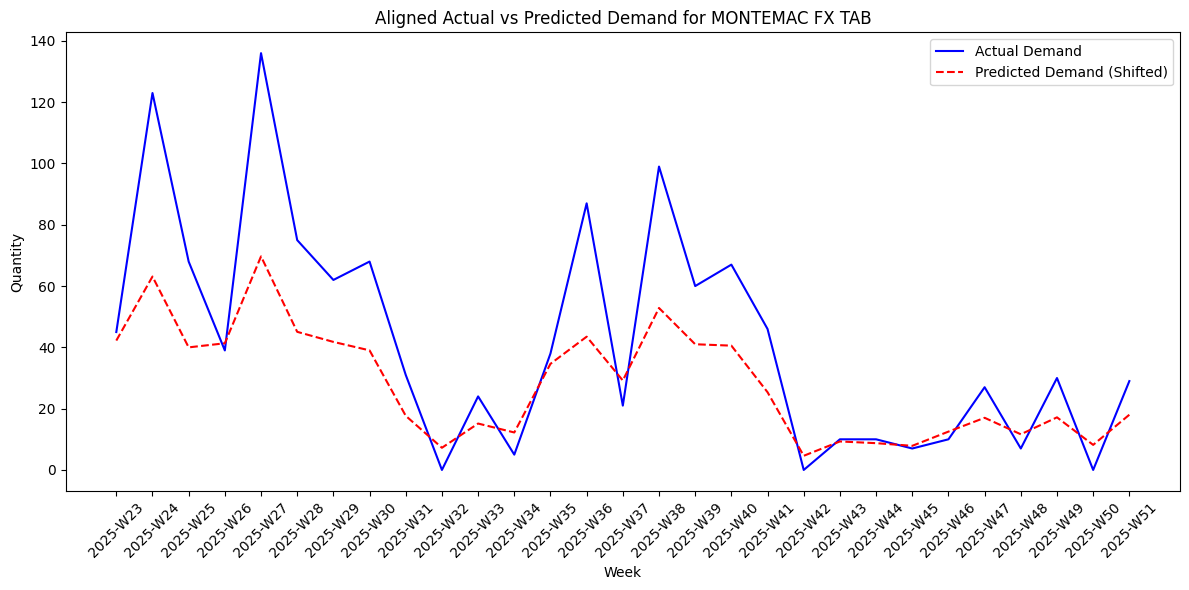

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


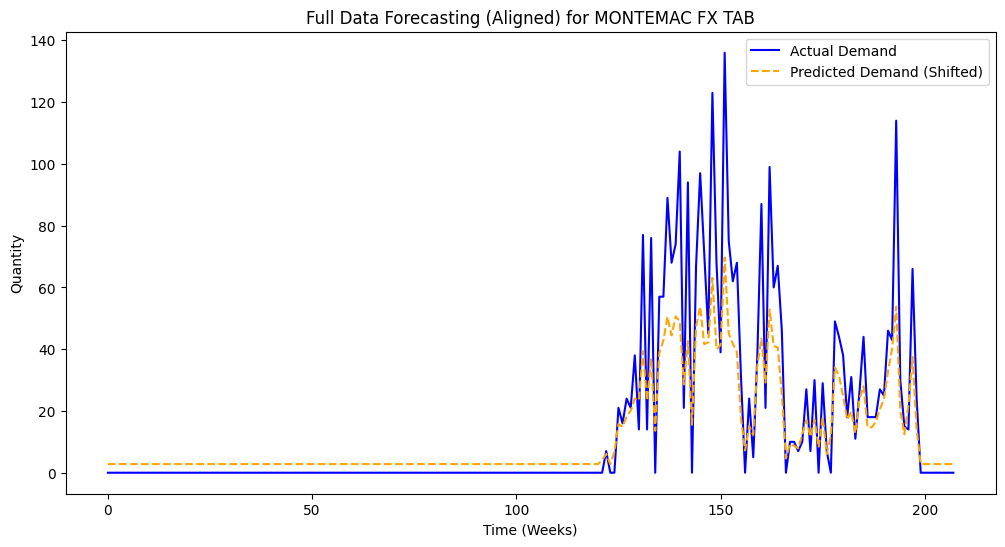

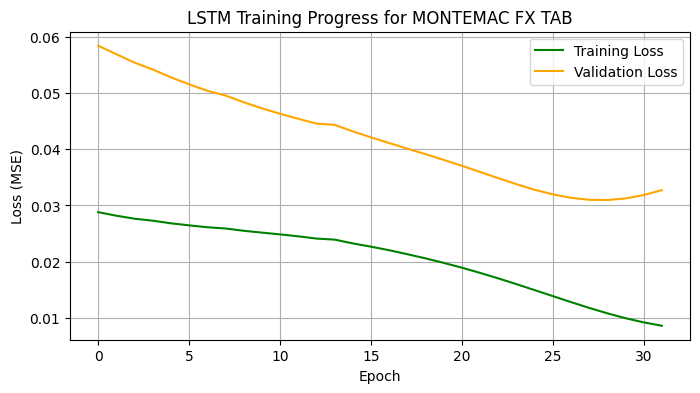

model summary:


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 2, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,957 (585.77 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 99,972 (390.52 KB)

history:
{'accuracy': [0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064, 0.8571428656578064], 'loss': [0.02880508452653885, 0.02817048504948616, 0.027637848630547523, 0.027282394468784332, 0.026819592341780663, 0.02645372785627842, 0.026117831468582153, 0.025893213227391243, 0.02548952028155327, 0.02515936829149723, 0.02484196610748768, 0.02450026571750641, 0.024100469425320625, 0.023913444951176643, 0.023238491266965866, 0.02

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Load dataset
file_path = "../data/demand_prediction_weekly.xlsx"
sales_data = pd.read_excel(file_path)

# 2️⃣ Display available medicines
unique_medicines = sales_data['Product_Name'].unique()
print("Available Medicines:\n", unique_medicines)

# 3️⃣ Select medicine dynamically
selected_medicine = input("Enter the medicine name from the list above: ")

# 4️⃣ Train LSTM model (includes preprocessing + evaluation internally)
model, scaler, history, rmse, smape, predictions, y_test_actual, accuracy, mae, X, y = train_pharmaceutical_lstm(
    sales_data, selected_medicine
)

# 5️⃣ Print model performance
print(f"\n📊 Model Evaluation for {selected_medicine}")
print("RMSE",rmse)
print("SMAPE:" ,smape)
print(" Mean Absolute Error (MAE):",mae)
print(f"✅ Accuracy (approx): {accuracy:.2f}%")


# 🔹 Recreate the week labels for the test set
time_steps = 2  # must match your LSTM training setup
time_labels = product_df['Week'].iloc[-len(y_test_actual):].reset_index(drop=True)

# 🔹 Shift predictions and actuals for alignment
shifted_weeks = time_labels[:-time_steps]                  # remove last 2 weeks (no future data)
shifted_predictions = predictions[time_steps:]             # remove first 2 predictions
trimmed_actual = y_test_actual[:len(shifted_predictions)]  # keep same length

# 🔹 Plot adjusted Actual vs Predicted Demand (Aligned)
plt.figure(figsize=(12, 6))
plt.plot(shifted_weeks, trimmed_actual, label='Actual Demand', color='blue')
plt.plot(shifted_weeks, shifted_predictions, label='Predicted Demand (Shifted)', color='red', linestyle='--')

plt.title(f"Aligned Actual vs Predicted Demand for {selected_medicine}")
plt.xlabel("Week")
plt.ylabel("Quantity")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()





# Plot actual vs predicted demand ON WHOLE DATA
predictions1 = scaler.inverse_transform(model.predict(X))
y1 = scaler.inverse_transform(y.reshape(-1, 1))

# For full-data alignment (optional)
shifted_predictions1 = predictions1[time_steps:]
trimmed_y1 = y1[:len(shifted_predictions1)]

plt.figure(figsize=(12,6))
plt.plot(trimmed_y1, label='Actual Demand', color='blue')
plt.plot(shifted_predictions1, label='Predicted Demand (Shifted)', color='orange', linestyle='--')
plt.title(f"Full Data Forecasting (Aligned) for {selected_medicine}")
plt.xlabel("Time (Weeks)")
plt.ylabel("Quantity")
plt.legend()
plt.show()


# 7️⃣ Plot Training & Validation Loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss', color='green')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title(f"LSTM Training Progress for {selected_medicine}")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()


print("model summary:")
model.summary()

print("history:")
print(history.history)


model saving

In [ ]:
#model.save("../saved models/pharma_lstm_model.keras")
